## **Importing Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re,json,nltk
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score,precision_score,recall_score,f1_score
import json
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import Dense, ReLU
from tensorflow.keras.layers import Embedding, BatchNormalization, Concatenate
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Activation,Embedding,Flatten,Bidirectional,MaxPooling2D, Conv1D, MaxPooling1D
from keras.optimizers import SGD,Adam
from keras import regularizers


In [2]:
#Load dataset
df = pd.read_excel('data.xlsx')

df.head()


,Source,Date,Text,Category,Polarity
0,BBC Bangla,2018-06-03 00:00:00,জয় বাংলা কাপ! তাও আবার স্বাধীনতার মাস মার্চে। ...,other,positive
1,BBC Bangla,2018-06-04 00:00:00,জয় বাংলা কাপ! তাও আবার স্বাধীনতার মাস মার্চে। ...,team,positive
2,BBC Bangla,15/6/2017,বাংলাদেশের পরে ভারতের সাপর্ট ই করি ?,team,positive
3,BBC Bangla,15/6/2020,সৌম্যকে বাদ দেওয়া হোক,batting,negative
4,BBC Bangla,27/1/2018,"প্রথমটি হচ্ছে, কোচ অত:পর সাকিব,সাকিব আর সাকিবর...",team,positive


In [3]:
#Show total columns
df.columns

Index(['Source', 'Date', 'Text', 'Category', 'Polarity'], dtype='object')

In [4]:
#Drop the unnecessary colums
df = df.drop(['Source', 'Date','Category'], axis=1)

In [5]:
df.head()


,Text,Polarity
0,জয় বাংলা কাপ! তাও আবার স্বাধীনতার মাস মার্চে। ...,positive
1,জয় বাংলা কাপ! তাও আবার স্বাধীনতার মাস মার্চে। ...,positive
2,বাংলাদেশের পরে ভারতের সাপর্ট ই করি ?,positive
3,সৌম্যকে বাদ দেওয়া হোক,negative
4,"প্রথমটি হচ্ছে, কোচ অত:পর সাকিব,সাকিব আর সাকিবর...",positive


In [6]:
df.describe()

,Text,Polarity
count,2979,2979
unique,2720,3
top,"এই পিচে বাংলাদেশকে ৪র্থ ইনিংসে ব্যাট করতে হবে,...",negative
freq,4,2152


In [7]:
#show total numbers of pos,neg and neutral comments
print("Total Reviews:",len(df),
      "\nTotal Positive Reviews:",len(df[df.Polarity =='positive']),
      "\nTotal Negative Reviews:",len(df[df.Polarity=='negative']),
      "\nTotal Neutral Reviews:",len(df[df.Polarity =='neutral']))

Total Reviews: 2979 
Total Positive Reviews: 566 
Total Negative Reviews: 2152 
Total Neutral Reviews: 261


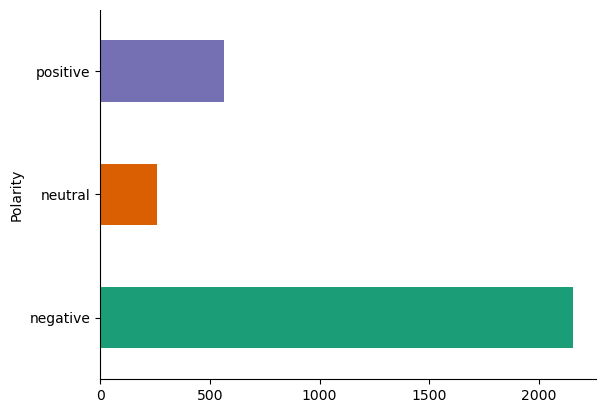

In [8]:
#visualize the data
df.groupby('Polarity').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [9]:
from plotly import graph_objs as go
temp = df.groupby('Polarity').count()['Text'].reset_index().sort_values(by='Text',ascending=False)
temp.style.background_gradient(cmap='Purples')

,Polarity,Text
0,negative,2152
2,positive,566
1,neutral,261


In [10]:
df.sample(n=5, random_state=0)[['Text', 'Polarity']]


,Text,Polarity
2671,মাসরাফি আর ভারতীয় লিজেন্ড জহির খাঁন এর উইকেট ই...,positive
538,অবহেলিত মমিনুল জন্য আজ এই টেষ্ট ড্র করতে পারলাম,positive
1628,বাংলাদেশের আবাল ক্রীড়া সাংবাদিক দের মাঠে নামায়...,negative
1412,এখন টেস্ট ও একি দশা। বাকি রইলো টি২০!,negative
1725,"আমাদের শান্তনা দুজন বোলার ৪ উইকেট পাইছে,এটা নি...",negative


In [11]:
#showing some random comments and their sentiments
sample_data = [10,100,250,650]
for i in sample_data:
      print(df.Text[i],'\n','Sentiment:-- ',df.Polarity[i],'\n')

,আমার বাংলাদেশ জিদবে #$ @ ইনশা আল্লাহ।। 
 Sentiment:--  positive 

ধন্যবাদ রাজ্জাককে সুযোগ দেওয়ার জন্য। 
 Sentiment:--  positive 

 আসেন এখন আমরা বাংলাদেশ টিমরে গাইলাই 
 Sentiment:--  negative 

 আরো আগে রাজ্জাকের প্রত্যাবর্তন করা দরকার ছিল 
 Sentiment:--  positive 



## **Data Preprocessing**

In [12]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\raquib\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
#Data Cleaning
def process_text(Text):
    Text = re.sub('[^\u0980-\u09FF]',' ',str(Text)) #removing unnecessary punctuation
    Text = re.sub('[?.`*^()!°¢܌Ͱ̰ߒנ~×Ҡߘ:ҰߑÍ|।;!,&%\'@#$><A-Za-z0+-9=./''""_০-৯]', '', str(Text))
    Text = re.sub(r'(\W)(?=\1)', '', str(Text))
    Text = re.sub(r'https?:\/\/.*[\r\n]*', '', str(Text), flags=re.MULTILINE)
    Text = re.sub(r'\<a href', ' ', str(Text))
    Text = re.sub(r'&amp;', '', str(Text))
    Text = re.sub(r'<br />', ' ', str(Text))
    Text = re.sub(r'\'', ' ', str(Text))
    Text = re.sub(r'ߑͰߑ̰ߒנ', '', str(Text))
    Text = re.sub(r'ߎɰߎɰߎɍ', '', str(Text))
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('bengali')) + r')\b\s*')
    Text = pattern.sub('', Text)
    return Text

In [14]:
# Apply the function into the dataframe
df['cleaned'] = df['Text'].apply(process_text)

# print some cleaned reviews from the dataset
sample_data = [10,100,250]
for i in sample_data:
     print('Original:\n',df.Text[i],'\nCleaned:\n',
           df.cleaned[i],'\n','Textiment:-- ',df.Polarity[i],'\n')

Original:
 ,আমার বাংলাদেশ জিদবে #$ @ ইনশা আল্লাহ।। 
Cleaned:
  বাংলাদেশ জিদবে ইনশা আল্লাহ  
 Textiment:--  positive 

Original:
 ধন্যবাদ রাজ্জাককে সুযোগ দেওয়ার জন্য। 
Cleaned:
 ধন্যবাদ াজ্জাককে সুযোগ ্য  
 Textiment:--  positive 

Original:
  আসেন এখন আমরা বাংলাদেশ টিমরে গাইলাই 
Cleaned:
  আসেন আমরা বাংলাদেশ মরে গাইলা 
 Textiment:--  negative 



Removing Low-length data


In [15]:
# Length of each Reveiws
df['length'] = df['cleaned'].apply(lambda x:len(x.split()))
# Remove the reviews with least words
lnt=len(df)
df = df.loc[df.length>3]
df = df.reset_index(drop = True)
print("After Cleaning:","\nRemoved {} Small Reviews".format(lnt-len(df)),
      "\nTotal Reviews:",len(df))

After Cleaning: 
Removed 357 Small Reviews 
Total Reviews: 2622


In [16]:
Positive_sent = df[df['Polarity']=='positive']
Negative_sent = df[df['Polarity']=='negative']
Neutral_sent = df[df['Polarity']=='neutral']

Taking only positive and Negative data

In [17]:
Positive = df[df.Polarity == 'positive']
Negative = df[df.Polarity == 'negative']
df = pd.concat([Positive, Negative], ignore_index=True)
df.Polarity.value_counts()

Polarity
negative    1943
positive     462
Name: count, dtype: int64

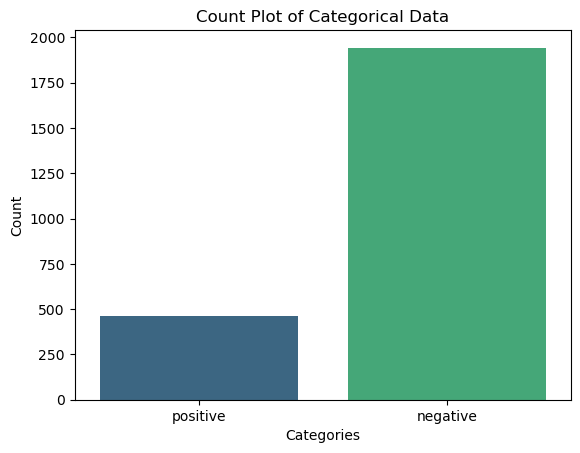

In [18]:
# visualizing positive and negative data
sns.countplot(x='Polarity', data=df, palette='viridis')
plt.title('Count Plot of Categorical Data')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.show()

Imbalance data

## Handling Imbalancedataset

In [19]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Polarity'])

In [20]:
df['labels']=y

In [21]:
df

,Text,Polarity,cleaned,length,labels
0,জয় বাংলা কাপ! তাও আবার স্বাধীনতার মাস মার্চে। ...,positive,জয় বাংলা কাপ স্ধীনতামাস মা্চে মাথা থেকে চমৎকাআ...,11,1
1,জয় বাংলা কাপ! তাও আবার স্বাধীনতার মাস মার্চে। ...,positive,জয় বাংলা কাপ স্ধীনতামাস মা্চে মাথা থেকে চমৎকাআ...,11,1
2,"প্রথমটি হচ্ছে, কোচ অত:পর সাকিব,সাকিব আর সাকিবর...",positive,প্রথমটি হচ্ছে কোচ অত সাব সাব সাবরে দলে াখা,9,1
3,"প্রথমটি হচ্ছে, কোচ অত:পর সাকিব,সাকিব আর সাকিবর...",positive,প্রথমটি হচ্ছে কোচ অত সাব সাব সাবরে দলে াখা,9,1
4,",আমার বাংলাদেশ জিদবে #$ @ ইনশা আল্লাহ।।",positive,বাংলাদেশ জিদবে ইনশা আল্লাহ,4,1
...,...,...,...,...,...
2400,নির্বাচকমণ্ডলী দের গালে জুতা মারা উচিত.. হালা...,negative,নি্চকমণ্ডলী দেগালে জুতা মাা হালাপুতরা টাকা খা...,19,0
2401,"বস ভাল করবে ইটাই আশা করি,দারুন এরজন ব্যাটিং অল...",negative,বস ভাল করবে ইটাআশা করি দাুন এরজন ব্টিং অলরাউন্ডা,9,0
2402,"বস ভাল করবে ইটাই আশা করি,দারুন এরজন ব্যাটিং অল...",negative,বস ভাল করবে ইটাআশা করি দাুন এরজন ব্টিং অলরাউন্ডা,9,0
2403,গুগল সার্চ করে মিনহাজের রানরেট দেখে নিন? এভারে...,negative,গুগল সা্চ করে মিনহাানরেট দেখে নিন এভােজ ানরেট ...,15,0


NameError: name 'lebels' is not defined

In [22]:
train1, test1 = train_test_split(df,random_state=69, test_size=0.2)
training_cleaned = []
testing_cleaned = []



train_cleaned=train1['cleaned'].values
train_labels=train1['labels'].values
for i in range(train_cleaned.shape[0]): 
    #print(train_sentences[i])
    x=str(train_cleaned[i])
    training_cleaned.append(x)
    
training_cleaned=np.array(training_cleaned)





test_cleaned=test1['cleaned'].values
test_labels=test1['labels'].values

for i in range(test_cleaned.shape[0]): 
    x=str(test_cleaned[i])
    testing_cleaned.append(x)
    
testing_cleaned=np.array(testing_cleaned)


train_labels=keras.utils.to_categorical(train_labels)


test_labels=keras.utils.to_categorical(test_labels)

In [23]:
print("Training Set Length: "+str(len(train1)))
print("Testing Set Length: "+str(len(test1)))
print("training_sentences shape: "+str(training_cleaned.shape))
print("testing_sentences shape: "+str(testing_cleaned.shape))
print("train_labels shape: "+str(train_labels.shape))
print("test_labels shape: "+str(test_labels.shape))

Training Set Length: 1924
Testing Set Length: 481
training_sentences shape: (1924,)
testing_sentences shape: (481,)
train_labels shape: (1924, 2)
test_labels shape: (481, 2)


In [33]:
from sklearn.utils import resample
import pandas as pd

# Combine training data and labels for resampling
train_combined = pd.concat([pd.DataFrame(training_cleaned), pd.DataFrame(train_labels.argmax(axis=1))], axis=1)
train_combined.columns = ['cleaned', 'labels']

# Separate the majority and minority classes
majority_class = train_combined[train_combined['labels'] == train_combined['labels'].mode()[0]]
minority_class = train_combined[train_combined['labels'] != train_combined['labels'].mode()[0]]

# Oversample the minority class
minority_class_oversampled = resample(minority_class, 
                                      replace=True,       # Sample with replacement
                                      n_samples=len(majority_class),  # Match majority class size
                                      random_state=42)    # For reproducibility

# Combine majority class with oversampled minority class
train_oversampled = pd.concat([majority_class, minority_class_oversampled])

# Shuffle the new dataset
train_oversampled = train_oversampled.sample(frac=1, random_state=42)

# Update training data and labels
training_cleaned = train_oversampled['cleaned'].values
train_labels = keras.utils.to_categorical(train_oversampled['labels'].values)


In [34]:
print(training_cleaned[1])
print(train_labels[0])

মনে িজে জিম্বোয়ে সবচেয়ে ফেভািট 
[0. 1.]


In [35]:
vocab_size = 25000
embedding_dim = 300
max_length = 100
trunc_type='post'
oov_tok = "<OOV>"

In [36]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_cleaned)
word_index = tokenizer.word_index
print(len(word_index))
print("Word index length:"+str(len(tokenizer.word_index)))

sequences = tokenizer.texts_to_sequences(training_cleaned)

padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(testing_cleaned)
testing_padded = pad_sequences(test_sequences,maxlen=max_length)


5485
Word index length:5485


In [37]:
print("Sentence :--> \n")
print(training_cleaned[2]+"\n")
print("Sentence Tokenized and Converted into Sequence :--> \n")
print(str(sequences[2])+"\n")
print("After Padding the Sequence with padding length 100 :--> \n")
print(padded[2])

Sentence :--> 

দল নি্চন থেকে শুু করে ব্যবস্থাপনায় চরম অনিয়ম ং অপেশাদািত্বেচরিত্ফুটে উঠেছে 

Sentence Tokenized and Converted into Sequence :--> 

[45, 350, 33, 280, 6, 1543, 1016, 1017, 60, 1544, 1018]

After Padding the Sequence with padding length 100 :--> 

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0   45  350   33  280    6 1543 1016 1017   60
 1544 1018]


In [39]:
print("Padded shape(training): "+str(padded.shape))
print("Padded shape(testing): "+str(testing_padded.shape))

Padded shape(training): (3104, 100)
Padded shape(testing): (481, 100)


Epoch 1/5
97/97 [==============================] - 20s 159ms/step - loss: 1.9544 - accuracy: 0.5509 - val_loss: 1.8411 - val_accuracy: 0.6341
Epoch 2/5
97/97 [==============================] - 14s 148ms/step - loss: 1.6443 - accuracy: 0.7339 - val_loss: 1.4617 - val_accuracy: 0.8025
Epoch 3/5
97/97 [==============================] - 14s 142ms/step - loss: 1.1330 - accuracy: 0.9362 - val_loss: 1.4533 - val_accuracy: 0.8108
Epoch 4/5
97/97 [==============================] - 13s 138ms/step - loss: 0.9087 - accuracy: 0.9803 - val_loss: 1.4311 - val_accuracy: 0.8358
Epoch 5/5
97/97 [==============================] - 14s 139ms/step - loss: 0.7781 - accuracy: 0.9878 - val_loss: 1.4021 - val_accuracy: 0.8316


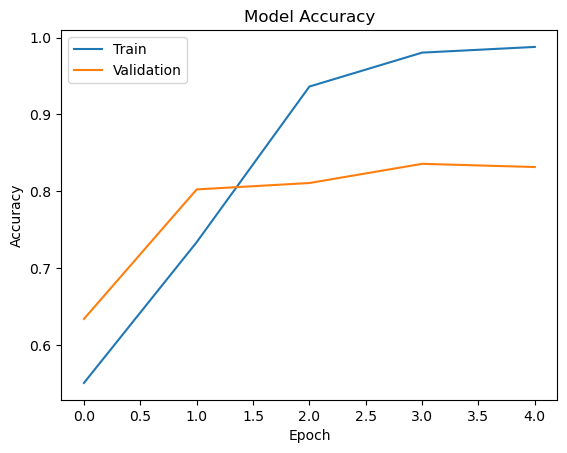

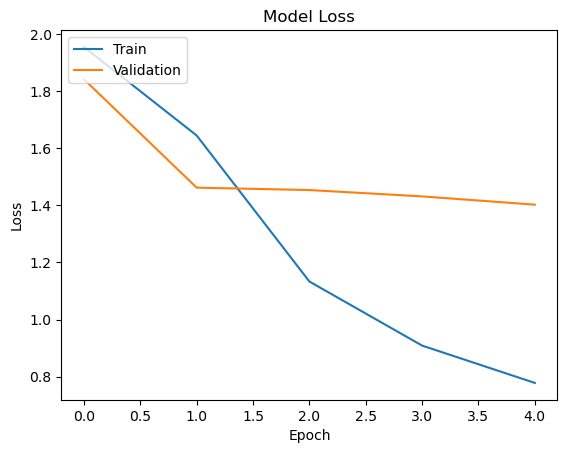

In [42]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, Bidirectional, LSTM, Dropout, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

# Define the model with regularization and increased dropout
with tf.device('/gpu:0'):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(Conv1D(200, kernel_size=3, activation='relu'))
    model.add(Conv1D(200, kernel_size=3, activation='relu'))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Dropout(0.6))  # Increased dropout to 0.6
    model.add(Bidirectional(LSTM(64)))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Flatten())
    model.add(Dense(100, kernel_regularizer=regularizers.l2(0.02), activation="relu"))  # Increased L2 penalty
    model.add(Dense(2, activation='softmax'))

# Compile the model with a reduced learning rate
adam = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

# Implement early stopping to avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    padded, 
    train_labels, 
    epochs=5, 
    validation_data=(testing_padded, test_labels), 
    callbacks=[early_stop], 
    verbose=1
)

# Plot the accuracy and loss curves to visualize overfitting
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
